In [1]:
import rasterio as ro
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
#import matplotlib.patches as mpatches
import random
#import math
#import pandas
#from scipy import optimize

#from keras_tuner.engine.hyperparameters import HyperParameters
from scipy.signal import savgol_filter

In [2]:
# load the data
ndvi = ro.open("Data/NDVI.grd")

covariates = ro.open("Data/covariates_250m_peninsula.grd")

p1 = ro.open("Data/newprec_01.tif")

p7 = ro.open("Data/newprec_07.tif")

fire_history = ro.open("Data/age.grd")

qa_data = ro.open("Data/QA.grd")

In [3]:
# read the shape of covariates
covariates_arr = covariates.read()

np.shape(covariates_arr)

(12, 172, 63)

In [4]:
# read the shape of NDVI
ndvi_arr = ndvi.read()

ndvi_arr.shape

(748, 172, 63)

In [5]:
# read the shape of QA
qa_arr = qa_data.read()

np.shape(qa_arr)

(748, 172, 63)

In [6]:
# read the shape of fire history
fire_arr = fire_history.read()

In [7]:
# read the precipitation data
p1_arr = p1.read(1)
p1_arr.shape
p7_arr = p7.read(1)
p7_arr.shape

p1_arr = p1_arr[:172,:63]
p7_arr = p7_arr[:172,:63]

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/matplotlib/image.py:488: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)


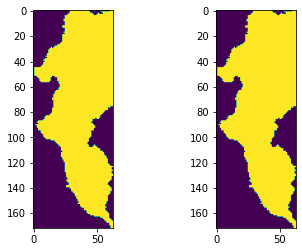

In [8]:
plt.subplot(1,2,1)
plt.imshow(p1_arr)

plt.subplot(1,2,2)
plt.imshow(p7_arr)

In [9]:
# replace the negative value with nan data in precipitation
# for m in range(0,172):
#   for n in range(0,63):
#     if p1_arr[:,m,n] < 0 :
#       p1_arr[:,m,n] = np.nan
#     else:
#       pass


# for m in range(0,172):
#   for n in range(0,63):
#     if p7_arr[:,m,n] < 0 :
#       p7_arr[:,m,n] = np.nan
#     else:
#       pass

p1_arr[p1_arr<0] = np.nan 
p7_arr[p7_arr<0] = np.nan 

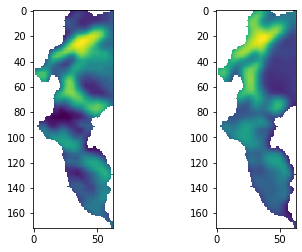

In [10]:
plt.subplot(1,2,1)
plt.imshow(p1_arr)

plt.subplot(1,2,2)
plt.imshow(p7_arr)

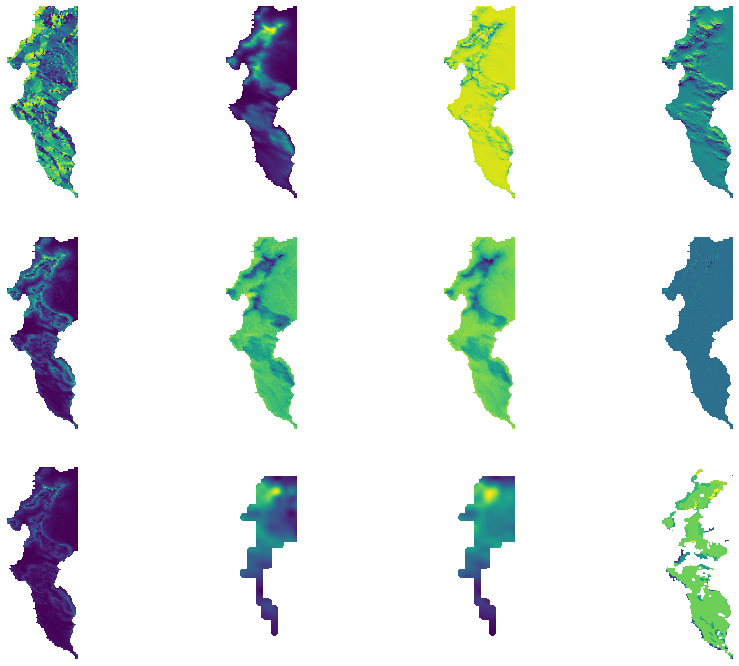

In [11]:
# plot out the initial covariates
plt.figure(figsize=(15,12))
for i in range(0,12):
    plt.subplot(3,4,i+1)
    plt.imshow(covariates_arr[i])
    plt.axis('off')

In [12]:
# replace the precipitation value
covariates_arr[9] = p1_arr
covariates_arr[10] = p7_arr

In [13]:
# read the shape of new covariates 
np.shape(covariates_arr)

(12, 172, 63)

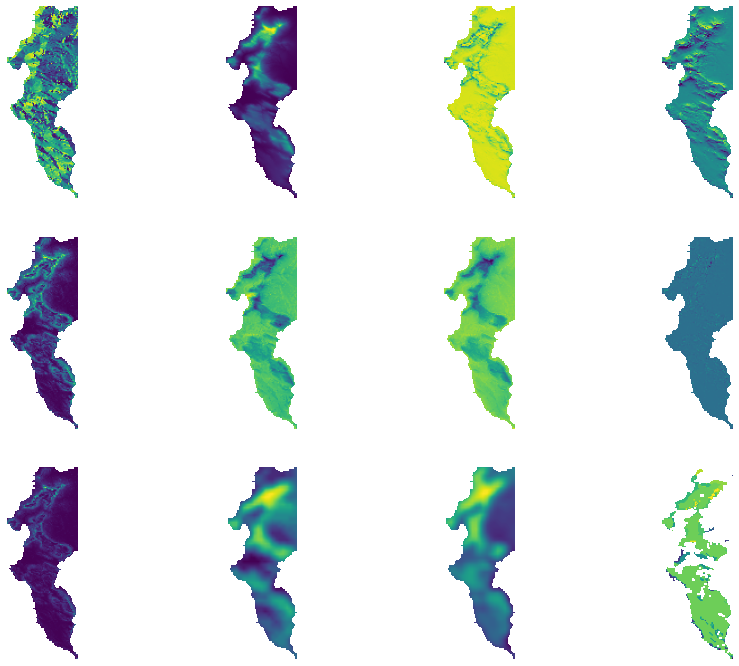

In [14]:
# plot out the updated covariates
plt.figure(figsize=(15,12))
for i in range(0,12):
    plt.subplot(3,4,i+1)
    plt.imshow(covariates_arr[i])
    plt.axis('off')

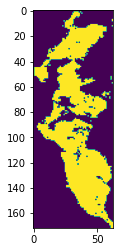

In [15]:
# create a mask based on the environmental variables and fire history
study_region_mask = np.zeros((ndvi.height,ndvi.width))


for i in range(study_region_mask.shape[0]):
    for j in range(study_region_mask.shape[1]):
        found_nan = False
        for var_index in range(covariates_arr.shape[0]):
            if np.isnan(covariates_arr[var_index,i,j]):
                found_nan =True
                break

        for time_step in range(fire_arr.shape[0]):
            if np.isnan(fire_arr[time_step,i,j]):
                found_nan =True
                break
        
        if found_nan:
            study_region_mask[i,j] = -1
        else:
            study_region_mask[i,j] = 1

plt.imshow(study_region_mask)

In [16]:
nan_value = 0

In [17]:
# a mask out function
def mask_layer(input_layer, mask_layer):
    input_layer[mask_layer==-1] = nan_value

    return input_layer

In [18]:
#savgol_filter to smooth the data
#ndvi_times = range(1,ndvi.count+1)

qa_value_array = qa_data.read()

#ndvi_smoothed = []
smoothed_dataset = np.zeros((ndvi.count,ndvi.height,ndvi.width))

for m in range(0,ndvi.height):
  for n in range(0,ndvi.width):

    ndvi_ori = ndvi_arr[:,m,n]
    
    if study_region_mask[m,n] ==-1:
      #ndvi_smoothed.append(ndvi_ori)
      smoothed_dataset[:,m,n] = ndvi_ori
      continue
    
    
    qa_value = qa_arr[:,m,n]
    # for i in ndvi_times:
    #   ndvi_data = ndvi.read(i)
    #   ndvi_pixel = ndvi_data[m,n]
    #   ndvi_ori.append(ndvi_pixel) 


    #   qa = qa_data.read(i)
    #   qa_pixel = qa[m,n]
    #   qa_value.append(qa_pixel) 

    smoothed = savgol_filter(ndvi_ori,7,2)

    for t in range(qa_value.shape[0]):
      if qa_value[t] == 0 and ndvi_ori[t]>0:
        smoothed[t] = ndvi_ori[t]
      # else:
      #   pass

    #ndvi_smoothed.append(smoothed)
    smoothed_dataset[:,m,n] = smoothed


#ndvi_smoothed = np.asarray(ndvi_smoothed)

In [19]:
# created the dataset contains ONLY UNSMOOTHED NDVI DATA
unsmoothed_dataset = ndvi.read()

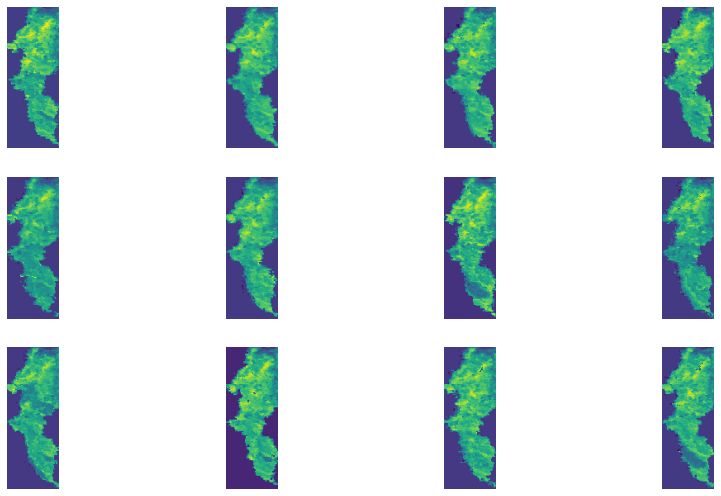

In [20]:
# visualize random 12 NDVI values of UNSMOOTHED NDVI DATASET
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(4,4,i)
    random_time = random.randint(0,ndvi.count-1)
    plt.imshow(unsmoothed_dataset[random_time,:,:])
    plt.axis('off')

In [21]:
# filter the UNSMOOTHED data with the mask

for time_steps in range(0,unsmoothed_dataset.shape[0]):
     unsmoothed_dataset[time_steps] = mask_layer(unsmoothed_dataset[time_steps],study_region_mask)


print(np.shape(unsmoothed_dataset))

(748, 172, 63)


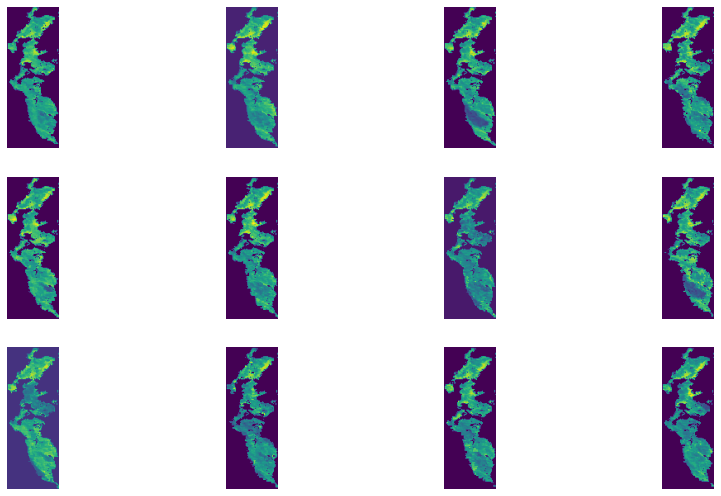

In [22]:
# visualize random 12 NDVI values of the masked data
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(4,4,i)
    random_time = random.randint(0,ndvi.count-1)
    plt.imshow(unsmoothed_dataset[random_time,:,:])
    plt.axis('off')

In [23]:
# from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [24]:
step_ahead = 46

In [25]:
smoothed_dataset = smoothed_dataset.reshape((748,172,63,1))

In [26]:
series = []
for i in range(0,ndvi.count-15-step_ahead+1):
    this_series_arr = []
    for j in range(0,15+step_ahead):
        this_series = smoothed_dataset[i+j,:,:,:]
        this_series_arr.append(this_series)

    series.append(this_series_arr)

series = np.asarray(series)

print(series.shape)

Y = np.empty((series.shape[0],15,172,63,step_ahead))

for k in range(1, step_ahead + 1):
    Y[:,:,:,:, k - 1] = series[:, k:k + 15,:,:, 0]

X = series[:,:15,:,:,:]

training_size = int(0.75*series.shape[0]) # 561

initial_ndvi = X[:training_size,...]
next_ndvi = Y[:training_size,...]

test_data_input = X[training_size:,...]
test_data_label = Y[training_size:,...]


(688, 61, 172, 63, 1)


In [27]:
np.shape(initial_ndvi), np.shape(next_ndvi)

((516, 15, 172, 63, 1), (516, 15, 172, 63, 46))

In [28]:
np.shape(test_data_input), np.shape(test_data_label)

((172, 15, 172, 63, 1), (172, 15, 172, 63, 46))

In [ ]:
def evaluate_method_performance(labeled_data, predicted, n_training_time_steps):
    n_test_time_steps = labeled_data.shape[0]
    time_step_ahead = labeled_data.shape[3]
    valid_label = []
    valid_predicted = []
    for t in range(n_test_time_steps):
        for m in range(172):
            for n in range(63):
                for a in range(time_step_ahead):
                    if qa_arr[n_training_time_steps+t+a,m,n] == 0 and ndvi_arr[n_training_time_steps+t+a,m,n]>0 and study_region_mask[m,n] == 1:
                        valid_label.append(labeled_data[t,m,n,a])
                        valid_predicted.append(predicted[t,m,n,a])
    print("R squared is: "+str(r2_score(valid_label,valid_predicted)))
    print("RMSE is: "+str(mean_squared_error(valid_label,valid_predicted, squared=False)))

In [29]:
# find valid input data for baseline1
valid_testlabel1 = []
valid_baseline1 = []


for m in range(0,172):
    for n in range(0,63):
        for i in range(initial_ndvi.shape[0], series.shape[0]):
            for tt in range(step_ahead):
                if qa_arr[i+tt,m,n] == 0 and ndvi_arr[i+tt,m,n]>0 and study_region_mask[m,n] == 1:
                    valid_testlabel1.append(test_data_label[i-initial_ndvi.shape[0],-1,m,n,tt])
                    a = []
                    for k in range(step_ahead):
                        a.append(test_data_input[i-initial_ndvi.shape[0],-1,m,n,0])
                    valid_baseline1.append(a)


In [30]:
np.shape(valid_testlabel1), np.shape(valid_baseline1)

((420627, 46), (420627, 46))

In [31]:
# performance of the baseline#1
rmse =  mean_squared_error(valid_testlabel1, valid_baseline1, squared=False)
print("RMSE of baseline 1 is " + str(rmse)+" time step: " + str(step_ahead))

RMSE of baseline 1 is 0.11056093571794728 time step: 46


In [32]:
r_2 = r2_score(valid_testlabel1, valid_baseline1)
print("R squared of baseline 1 is " + str(r_2)+" time step: " + str(step_ahead))

R squared of baseline 1 is 0.2910842099178645 time step: 46


In [33]:
# find valid input data for baseline1
valid_baseline2 = []

for m in range(0,172):
    for n in range(0,63):
        for i in range(initial_ndvi.shape[0], series.shape[0]):
            if qa_arr[i,m,n] == 0 and ndvi_arr[i,m,n]>0 and study_region_mask[m,n] == 1:
                pred_baseline2 = test_data_input[i-initial_ndvi.shape[0], ::, m, n, 0]
                a = []
                for k in range(step_ahead):
                    a.append(np.mean(pred_baseline2,axis = 0))
                valid_baseline2.append(a)

print(np.shape(valid_baseline2))

(420627, 46)


In [34]:
# performance of the baseline#2
# valid_testlabel2 = np.asarray(valid_testlabel2)
# valid_baseline2 = np.asarray(valid_baseline2)
rmse =  mean_squared_error(valid_testlabel1, valid_baseline2, squared=False)
print("RMSE of baseline 2 is " + str(rmse)+" time step: " + str(step_ahead))

RMSE of baseline 2 is 0.09917635219706643 time step: 46


In [35]:
r_2 = r2_score(valid_testlabel1, valid_baseline2)
print("R squared of baseline 2 is " + str(r_2)+" time step: " + str(step_ahead))

R squared of baseline 2 is 0.42905396850777544 time step: 46
